In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
import modules.io as io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import tensorflow as tf

In [2]:
DATA_KEY    = "VAL"
#CONFIG_FILE = '../config/googlenet_c30_train300k_aug10_clean.yaml'
CONFIG_FILE = '../config/unet_c30_train300k_aug10_clean.yaml'
LOAD = True

config      = io.load_yaml(CONFIG_FILE)
config['MODEL_DIR'] = config['MODEL_DIR'].replace('.','..')
config['DROPOUT'] = 0.15

SCALE = config['CROP_DIMS']/2*config['SPACING']

In [3]:
import factories.dataset_factory as dataset_factory

data    = dataset_factory.get(config, DATA_KEY)

231it [00:00, 3832.82it/s]

centering images



100%|██████████| 231/231 [00:03<00:00, 76.19it/s]


In [4]:
import factories.model_factory as model_factory

model = model_factory.get(config)
if LOAD: model.load()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Tensor("unet/layer1/conv2d_1/leaky_re_lu/LeakyRelu:0", shape=(?, 160, 160, 64), dtype=float32) Tensor("unet/layer1/pool:0", shape=(?, 80, 80, 64), dtype=float32)
Tensor("unet/layer2/conv2d_1/leaky_re_lu/LeakyRelu:0", shape=(?, 80, 80, 128), dtype=float32) Tensor("unet/layer2/pool:0", shape=(?, 40, 40, 128), dtype=float32)
Tensor("unet/layer3/conv2d_1/leaky_re_lu/LeakyRelu:0", shape=(?, 40, 40, 256), dtype=float32) Tensor("unet/layer3/pool:0", shape=(?, 20, 20, 256), dtype=float32)
Tensor("unet/layer4/conv2d_1/leaky_re_lu/LeakyRelu:0", shape=(?, 20, 20, 512), dtype=float32) Tensor("unet/layer4/pool:0", shape=(?, 10, 10, 512), 

NotFoundError: ../results/unet_c30_train300k_aug10_clean/model; No such file or directory

In [ ]:
tensor_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
for t in tensor_list:
    print(t)

In [ ]:
import factories.preprocessor_factory as prepro_factory

preprocessor = prepro_factory.get(config)

In [ ]:
import factories.postprocessor_factory as postpro_factory

postprocessor = postpro_factory.get(config)

In [ ]:
X = np.array([preprocessor(x) for x in data[0]])
print(X.shape)

In [ ]:
op = tf.get_default_graph().get_tensor_by_name("unet/dropout/random_uniform:0")
print(op)

In [10]:
out = model.sess.run(op, {model.x:X[0][np.newaxis,:,:,:]})
print(out.shape)
print(out[:10])

(1, 9216)
[[0.2350297  0.6707243  0.87538326 ... 0.12027669 0.13870561 0.21203566]]


In [11]:
INDEX = 1
N = 100
#model.sample()
contours = []
for i in range(N):
    yhat = model.predict(X[INDEX])
    c    = postprocessor(yhat)
    contours.append(c)

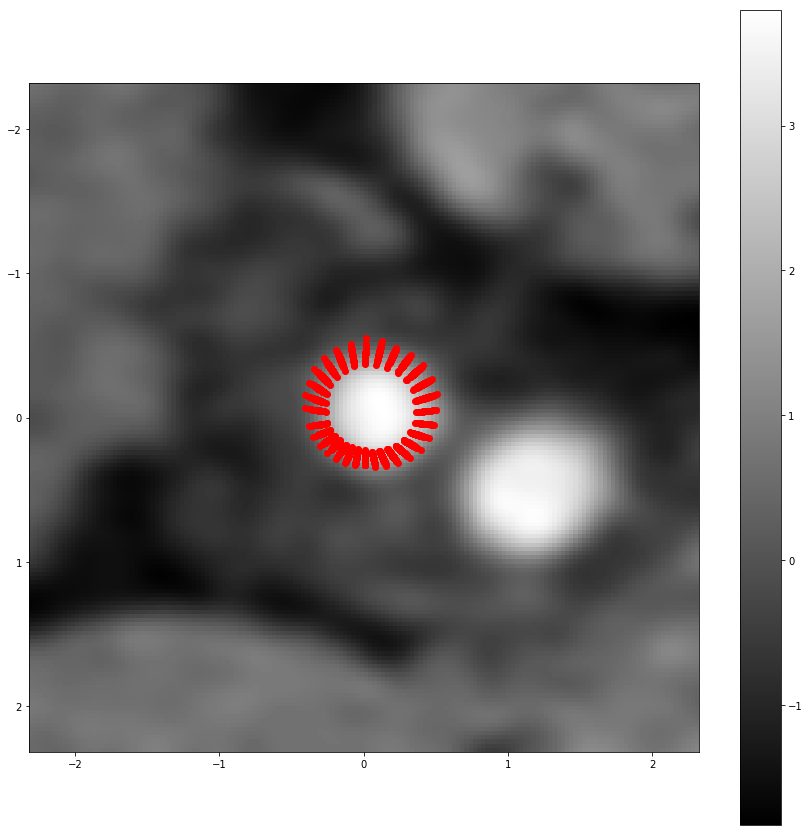

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(X[INDEX,:,:,0], extent=[-SCALE, SCALE, SCALE, -SCALE], cmap='gray')
for c in contours:
    plt.plot(c[:,0], c[:,1], color='r', marker='o', linestyle='')
plt.colorbar()
plt.show()

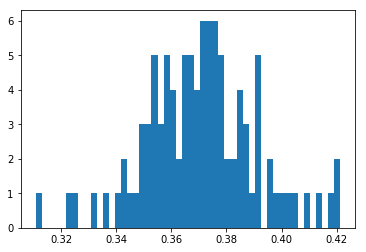

In [13]:
radiuses = []
for c in contours:
    cc = c-np.mean(c,axis=0)
    rs = np.sqrt(np.sum(cc**2,axis=1))
    r  = np.mean(rs)
    radiuses.append(r)

plt.figure()
plt.hist(radiuses, bins=50, label='radius')
plt.show()

In [14]:
from tqdm import tqdm
N = 20
r_means = []
r_stds  = []

for i in tqdm(range(X.shape[0])):
    radiuses = []
    
    for j in range(N):
        yhat = model.predict(X[i])
        c    = postprocessor(yhat)
    
        cc = c-np.mean(c,axis=0)
        rs = np.sqrt(np.sum(cc**2,axis=1))
        r  = np.mean(rs)
        radiuses.append(r)
        
    r_means.append(np.mean(radiuses))
    r_stds.append(np.std(radiuses))
    
r_means = np.array(r_means)
r_stds   = np.array(r_stds)
r_stds_norm = r_stds/r_means

  5%|▍         | 182/3786 [01:21<26:58,  2.23it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(r_means, r_stds, marker='o', linestyle='', label='predicted mean radius std')
plt.legend()
plt.xlabel('radius')
plt.ylabel('mean radius std')
plt.ylim(0,0.15)
plt.savefig('radius_std.png',dpi=300)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(r_means, r_stds_norm, marker='o', linestyle='', label='predicted mean radius std')
plt.legend()
plt.xlabel('radius')
plt.ylabel('normalized mean radius std')
plt.ylim(0,0.5)
plt.savefig('norm_radius_std.png',dpi=300)
plt.show()